<h1><strong><center>E-MDS120-1 22HDeep Learning HØST2022</center></strong></h1>
<h3><strong><center>Godspower Ogaga Uti.</center></strong></h3>
<h1><strong><center>University of Stavanger.</center></strong></h1>

In [1]:
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
import warnings
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
sb.set_style("whitegrid")
warnings.filterwarnings("ignore")
print("Running Panda Version:"+ pd.__version__)
print("Running Python {0}.{1}".format(sys.version_info[:2][0],sys.version_info[:2][1]))

2022-11-13 18:34:47.425034: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Running Panda Version:1.4.2
Running Python 3.10


In [2]:
df = pd.read_csv('data_.csv',delimiter=";",parse_dates=True)

In [3]:
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns.')

The dataset has 144 rows and 2 columns.


In [4]:
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
df.info()#quick description of the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


<AxesSubplot: xlabel='Month'>

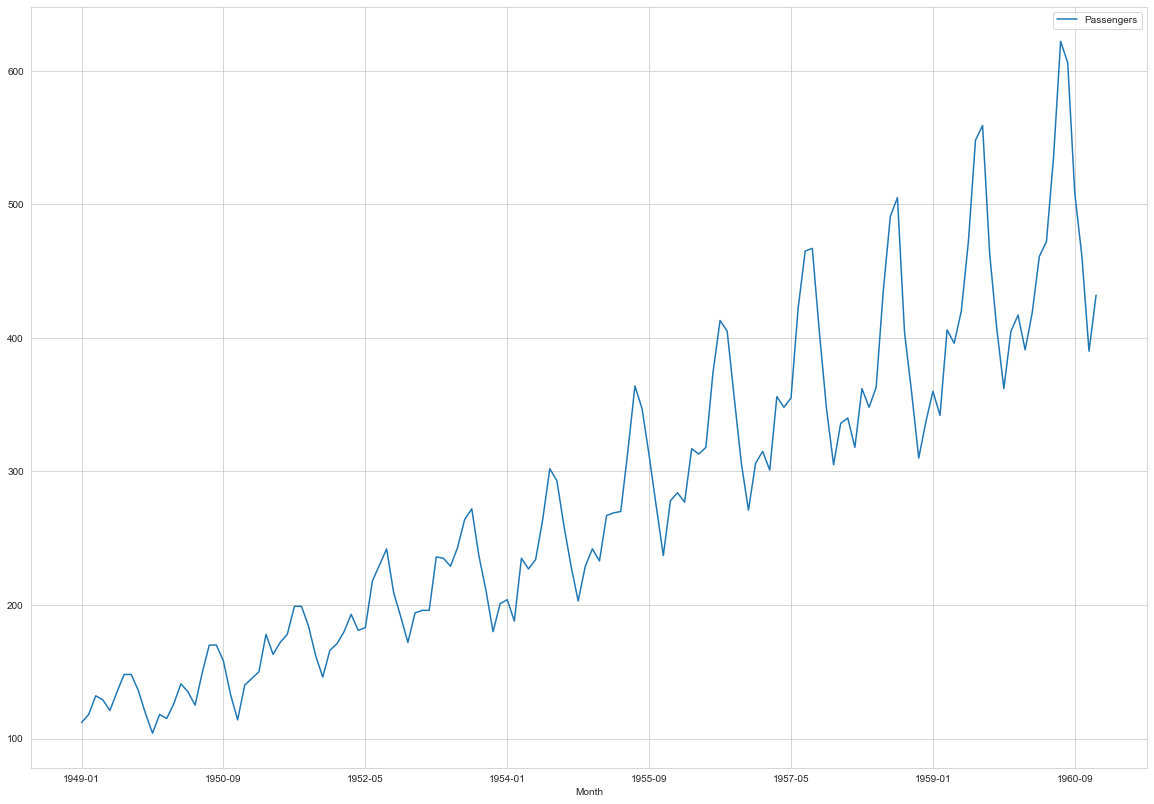

In [6]:
df.plot( 'Month' , 'Passengers' ,figsize=(20, 14),)

### Feature creation (Date decomposition)

In [7]:
def check_for_leap_year(year):
    if (year%4 == 0 and year % 100 != 0) or (year%400 == 0) :
        return True
    return False

In [8]:
def decode_date(date_str):
  date_ = datetime.strptime(date_str, '%Y-%m')
  return pd.Series([date_.year,date_.month])

In [9]:
df[['year','month']] = df.pop('Month').apply(decode_date)

In [10]:
df.index = range(1, len(df) + 1 )

In [11]:
df.head()

,Passengers,year,month
1,112,1949,1
2,118,1949,2
3,132,1949,3
4,129,1949,4
5,121,1949,5


In [12]:
daily_pass = []
for row in  zip(df['Passengers'], df['month'],df['year']):
    if check_for_leap_year(row[2]) and row[1] == 2:
        daily_pass.append(row[0] / 29)
    elif row[1] == 2:
        daily_pass.append(row[0] / 28)
    elif row[1] in [4,6,9,11]:
        daily_pass.append(row[0] / 30)
    else:
        daily_pass.append(row[0] / 31)  

In [13]:
df["daily_avg_passengers"] = daily_pass

In [14]:
df.head()

,Passengers,year,month,daily_avg_passengers
1,112,1949,1,3.612903
2,118,1949,2,4.214286
3,132,1949,3,4.258065
4,129,1949,4,4.300000
5,121,1949,5,3.903226


array([<AxesSubplot: >, <AxesSubplot: >], dtype=object)

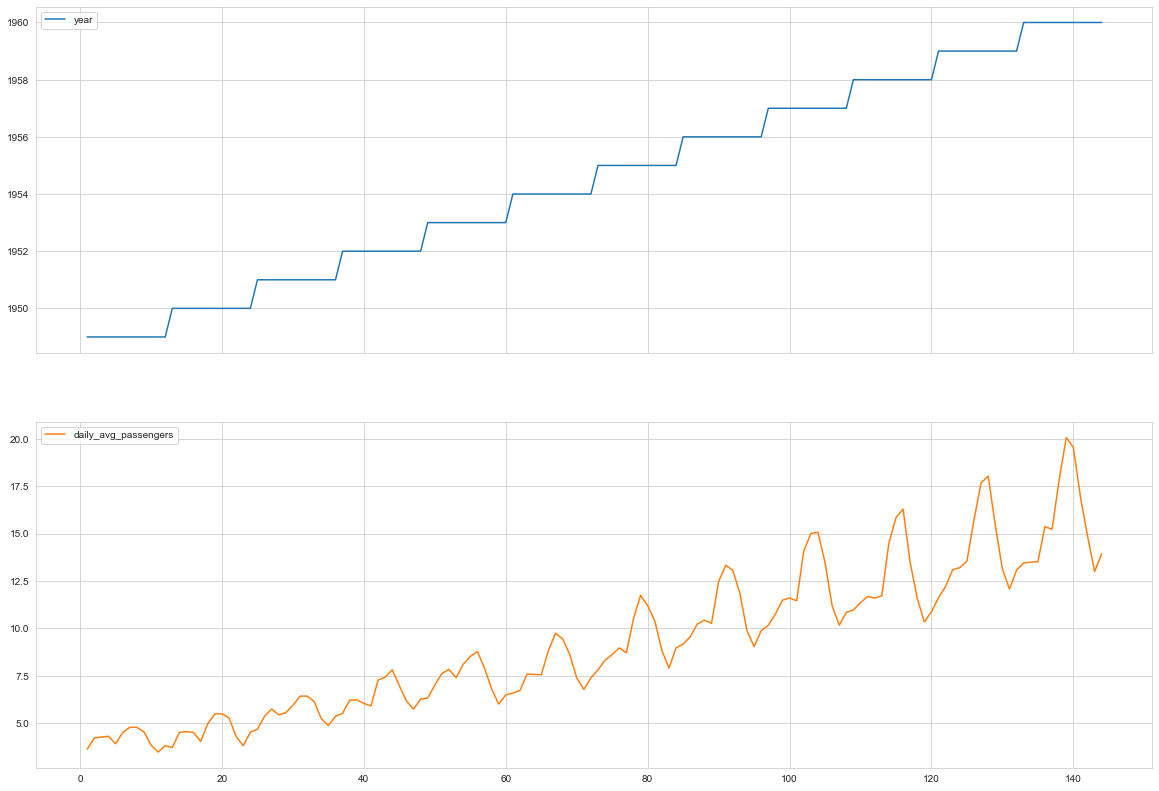

In [15]:
df[["year","daily_avg_passengers"]].plot(subplots=True,figsize=(20, 14))

In [16]:
unique_year_list = df.drop_duplicates(subset = ["year"])["year"].values.tolist()

In [17]:
unique_year_list

[1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960]

{1949: 1520, 1950: 1676, 1951: 2042, 1952: 2364, 1953: 2700, 1954: 2867, 1955: 3408, 1956: 3939, 1957: 4421, 1958: 4572, 1959: 5140, 1960: 5714}


Text(0.5, 0, 'Years')

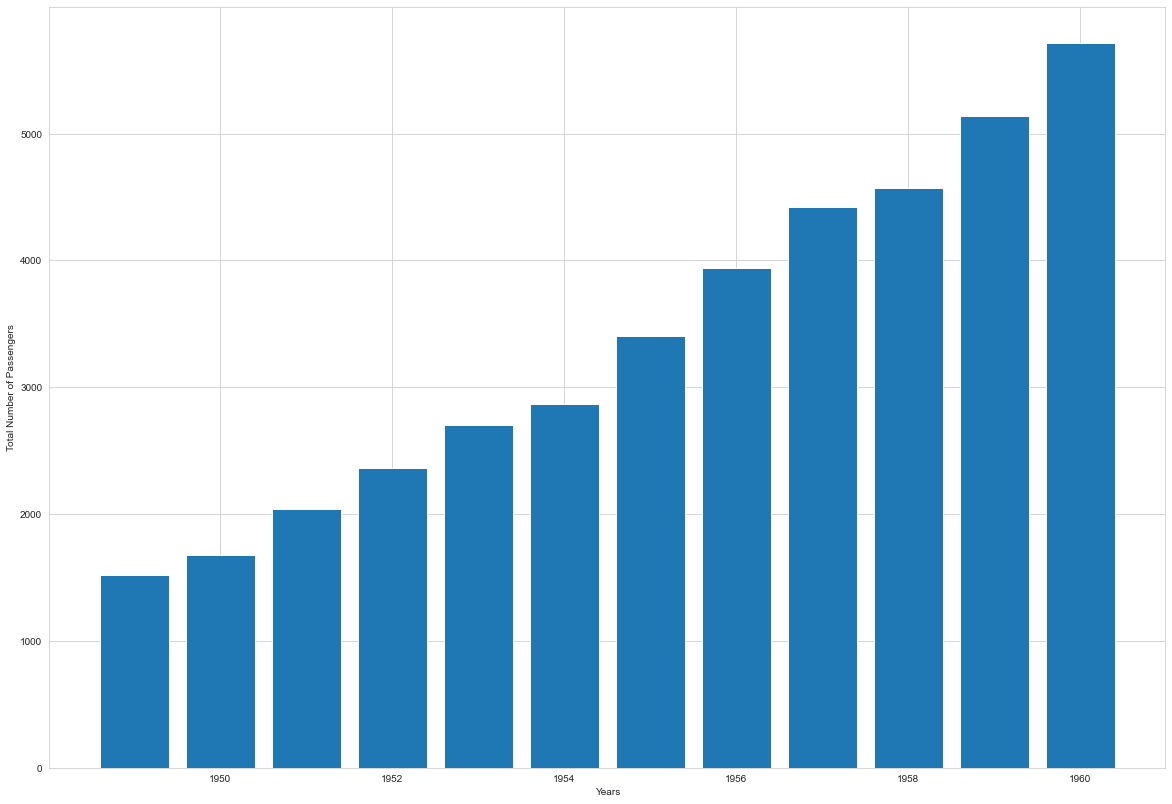

In [18]:
year_passenger = {}
for x in unique_year_list:
    aux = df.loc[df['year'] == x]
    Total = aux['Passengers'].sum()
    year_passenger[x] = Total
   
print(year_passenger)
plt.figure(figsize=(20, 14))   
plt.bar(list(year_passenger.keys()), year_passenger.values())
plt.ylabel('Total Number of Passengers')
plt.xlabel('Years')

In [19]:
#df.plot("year","daily_avg_passengers",figsize=(20, 14),kind="bar",rot=45)

In [20]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.000000,180.000000,265.500000,360.500000,622.000000
year,144.0,1954.500000,3.464102,1949.000000,1951.750000,1954.500000,1957.250000,1960.000000
month,144.0,6.500000,3.464102,1.000000,3.750000,6.500000,9.250000,12.000000
daily_avg_passengers,144.0,9.202143,3.906321,3.466667,5.983333,8.671505,11.717742,20.064516


In [21]:
df["Passengers"].max()

622

In [22]:
df["Passengers"].min()

104

In [23]:
df.loc[df['daily_avg_passengers'] == df["daily_avg_passengers"].max()] #Day with the highest number of passengers

,Passengers,year,month,daily_avg_passengers
139,622,1960,7,20.064516


In [24]:
df.loc[df['daily_avg_passengers'] == df["daily_avg_passengers"].min()] #Date with the lowest number of passengers

,Passengers,year,month,daily_avg_passengers
11,104,1949,11,3.466667


In [25]:
df = df[["daily_avg_passengers"]]

In [26]:
df.head()

,daily_avg_passengers
1,3.612903
2,4.214286
3,4.258065
4,4.300000
5,3.903226


### Splitting the dataset

In [27]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

In [28]:
print(f'Train shape : {train_df.shape}  Test shape : {test_df.shape} and Validation shape : {val_df.shape}')

Train shape : (100, 1)  Test shape : (15, 1) and Validation shape : (29, 1)


### Normalization of  the Dataset

In [29]:
train_max = train_df.max()
train_min = train_df.min()
train = (train_df - train_min) / (train_max - train_min )
val = (val_df - train_min) / (train_max - train_min )
test = (test_df - train_min) / (train_max - train_min )

In [30]:
 #train.drop(["month","year"],inplace=True,axis=1)
train.head()

,daily_avg_passengers
1,0.014837
2,0.075855
3,0.080297
4,0.084552
5,0.044294


In [31]:
val.head()

,daily_avg_passengers
101,0.810168
102,1.075496
103,1.170194
104,1.176740
105,1.014619


In [32]:
test.head()

,daily_avg_passengers
130,0.980362
131,0.872573
132,0.973816
133,1.013092
134,1.016252


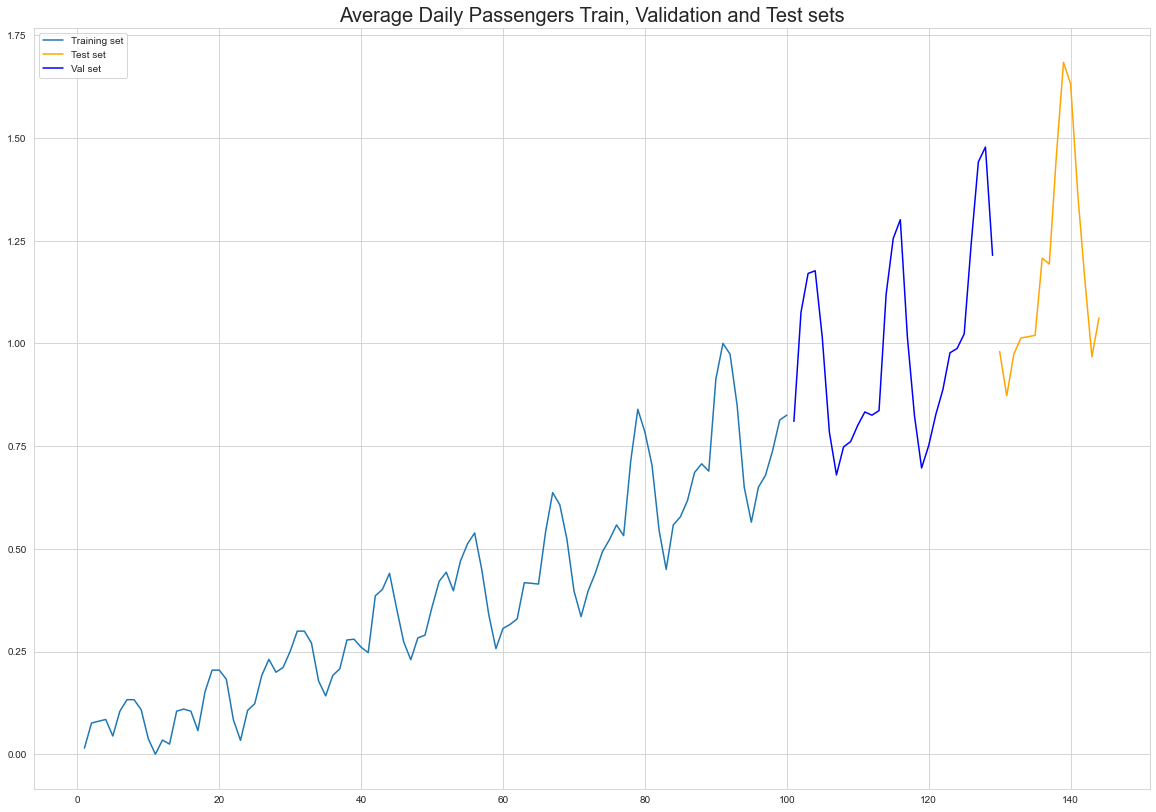

In [33]:
plt.rcParams["figure.figsize"] = (20,14)
plt.title('Average Daily Passengers Train, Validation and Test sets', size=20)
plt.plot(train['daily_avg_passengers'], label='Training set')
plt.plot(test['daily_avg_passengers'], label='Test set', color='orange')
plt.plot(val['daily_avg_passengers'], label='Val set', color='blue')
plt.legend()

In [34]:
def create_window(df_col,wind_size):
    X , y = ([] for x in range(2))
    df_col = df_col.to_numpy()
    for i in range(len(df_col) - wind_size):
        obs = [[x] for x in df_col[i:i+wind_size]]
        X.append(obs)
        aux = df_col[i+wind_size]
        y.append(aux)
    return np.asarray(X),np.asarray(y)

In [35]:
X_train, y_train  = create_window(train['daily_avg_passengers'],2)

In [36]:
print(f'Feature shape : {X_train.shape}  Label shape : {y_train.shape}')

Feature shape : (98, 2, 1)  Label shape : (98,)


In [37]:
X_val, y_val  = create_window(val['daily_avg_passengers'],2)

In [38]:
print(f'Feature shape : {X_val.shape}  Label shape : {y_val.shape}')

Feature shape : (27, 2, 1)  Label shape : (27,)


In [39]:
X_test, y_test  = create_window(test['daily_avg_passengers'],2)

In [40]:
print(f'Feature shape : {X_test.shape}  Label shape : {y_test.shape}')

Feature shape : (13, 2, 1)  Label shape : (13,)


In [41]:
model = keras.models.Sequential([
    keras.layers.LSTM(25, input_shape=(2, 1), activation='relu'),
    keras.layers.Dense(5),

    keras.layers.Dense(1,"linear")])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,mode='min')
#check_point = keras.callbacks.ModelCheckpoint('model',save_best_only=True,monitor='val_loss')
model.compile(loss=tf.keras.losses.MeanSquaredError(),optimizer=tf.keras.optimizers.Adam(lr=0.0001),metrics = [tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25)                2700      
                                                                 
 dense (Dense)               (None, 5)                 130       
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 2,836
Trainable params: 2,836
Non-trainable params: 0
_________________________________________________________________


2022-11-13 18:34:52.189338: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [42]:
model.fit(X_train, y_train,epochs=500,validation_data=(X_val, y_val), callbacks=[early_stopping],verbose=1)

Epoch 1/500
4/4 [==============================] - 1s 70ms/step - loss: 0.2183 - root_mean_squared_error: 0.4672 - val_loss: 1.0879 - val_root_mean_squared_error: 1.0430
Epoch 2/500
4/4 [==============================] - 0s 8ms/step - loss: 0.2158 - root_mean_squared_error: 0.4645 - val_loss: 1.0796 - val_root_mean_squared_error: 1.0390
Epoch 3/500
4/4 [==============================] - 0s 8ms/step - loss: 0.2134 - root_mean_squared_error: 0.4620 - val_loss: 1.0717 - val_root_mean_squared_error: 1.0352
Epoch 4/500
4/4 [==============================] - 0s 9ms/step - loss: 0.2111 - root_mean_squared_error: 0.4595 - val_loss: 1.0637 - val_root_mean_squared_error: 1.0313
Epoch 5/500
4/4 [==============================] - 0s 10ms/step - loss: 0.2088 - root_mean_squared_error: 0.4570 - val_loss: 1.0553 - val_root_mean_squared_error: 1.0273
Epoch 6/500
4/4 [==============================] - 0s 9ms/step - loss: 0.2064 - root_mean_squared_error: 0.4543 - val_loss: 1.0470 - val_root_mean_square

4/4 [==============================] - 0s 8ms/step - loss: 0.0601 - root_mean_squared_error: 0.2451 - val_loss: 0.4496 - val_root_mean_squared_error: 0.6705
Epoch 98/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0592 - root_mean_squared_error: 0.2434 - val_loss: 0.4446 - val_root_mean_squared_error: 0.6668
Epoch 99/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0584 - root_mean_squared_error: 0.2416 - val_loss: 0.4396 - val_root_mean_squared_error: 0.6630
Epoch 100/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0575 - root_mean_squared_error: 0.2398 - val_loss: 0.4350 - val_root_mean_squared_error: 0.6595
Epoch 101/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0567 - root_mean_squared_error: 0.2381 - val_loss: 0.4299 - val_root_mean_squared_error: 0.6557
Epoch 102/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0558 - root_mean_squared_error: 0.2363 - val_loss: 0.4251 - val_root_mean_squared_erro

4/4 [==============================] - 0s 7ms/step - loss: 0.0325 - root_mean_squared_error: 0.1802 - val_loss: 0.2609 - val_root_mean_squared_error: 0.5108
Epoch 146/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0321 - root_mean_squared_error: 0.1791 - val_loss: 0.2573 - val_root_mean_squared_error: 0.5072
Epoch 147/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0317 - root_mean_squared_error: 0.1781 - val_loss: 0.2539 - val_root_mean_squared_error: 0.5039
Epoch 148/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0314 - root_mean_squared_error: 0.1771 - val_loss: 0.2508 - val_root_mean_squared_error: 0.5008
Epoch 149/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0311 - root_mean_squared_error: 0.1762 - val_loss: 0.2480 - val_root_mean_squared_error: 0.4980
Epoch 150/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0308 - root_mean_squared_error: 0.1754 - val_loss: 0.2455 - val_root_mean_squared_er

Epoch 193/500
4/4 [==============================] - 0s 7ms/step - loss: 0.0226 - root_mean_squared_error: 0.1505 - val_loss: 0.1685 - val_root_mean_squared_error: 0.4105
Epoch 194/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0225 - root_mean_squared_error: 0.1501 - val_loss: 0.1671 - val_root_mean_squared_error: 0.4088
Epoch 195/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0224 - root_mean_squared_error: 0.1496 - val_loss: 0.1652 - val_root_mean_squared_error: 0.4064
Epoch 196/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0222 - root_mean_squared_error: 0.1490 - val_loss: 0.1630 - val_root_mean_squared_error: 0.4037
Epoch 197/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0221 - root_mean_squared_error: 0.1485 - val_loss: 0.1611 - val_root_mean_squared_error: 0.4014
Epoch 198/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0219 - root_mean_squared_error: 0.1480 - val_loss: 0.1595 - val_root_m

Epoch 241/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0172 - root_mean_squared_error: 0.1313 - val_loss: 0.1167 - val_root_mean_squared_error: 0.3415
Epoch 242/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0172 - root_mean_squared_error: 0.1310 - val_loss: 0.1160 - val_root_mean_squared_error: 0.3406
Epoch 243/500
4/4 [==============================] - 0s 7ms/step - loss: 0.0171 - root_mean_squared_error: 0.1306 - val_loss: 0.1153 - val_root_mean_squared_error: 0.3396
Epoch 244/500
4/4 [==============================] - 0s 7ms/step - loss: 0.0170 - root_mean_squared_error: 0.1302 - val_loss: 0.1149 - val_root_mean_squared_error: 0.3390
Epoch 245/500
4/4 [==============================] - 0s 7ms/step - loss: 0.0169 - root_mean_squared_error: 0.1298 - val_loss: 0.1145 - val_root_mean_squared_error: 0.3384
Epoch 246/500
4/4 [==============================] - 0s 7ms/step - loss: 0.0168 - root_mean_squared_error: 0.1295 - val_loss: 0.1142 - val_root_m

Epoch 289/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0130 - root_mean_squared_error: 0.1142 - val_loss: 0.0880 - val_root_mean_squared_error: 0.2966
Epoch 290/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0129 - root_mean_squared_error: 0.1138 - val_loss: 0.0870 - val_root_mean_squared_error: 0.2950
Epoch 291/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0129 - root_mean_squared_error: 0.1134 - val_loss: 0.0854 - val_root_mean_squared_error: 0.2923
Epoch 292/500
4/4 [==============================] - 0s 7ms/step - loss: 0.0127 - root_mean_squared_error: 0.1129 - val_loss: 0.0841 - val_root_mean_squared_error: 0.2899
Epoch 293/500
4/4 [==============================] - 0s 7ms/step - loss: 0.0126 - root_mean_squared_error: 0.1124 - val_loss: 0.0831 - val_root_mean_squared_error: 0.2882
Epoch 294/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0126 - root_mean_squared_error: 0.1120 - val_loss: 0.0821 - val_root_m

In [43]:
predictions = model.predict(X_test).flatten()

1/1 [==============================] - 0s 140ms/step


In [44]:
res_df = pd.DataFrame(data={"Model Predictions":predictions,"Ground Truth":y_test})

In [45]:
res_df

,Model Predictions,Ground Truth
0,0.787038,0.973816
1,0.781136,1.013092
2,0.824866,1.016252
3,0.838621,1.019638
4,0.840632,1.207397
5,0.894371,1.193105
6,0.955935,1.457670
7,1.026453,1.684050
8,1.193435,1.631682
9,1.267909,1.366354


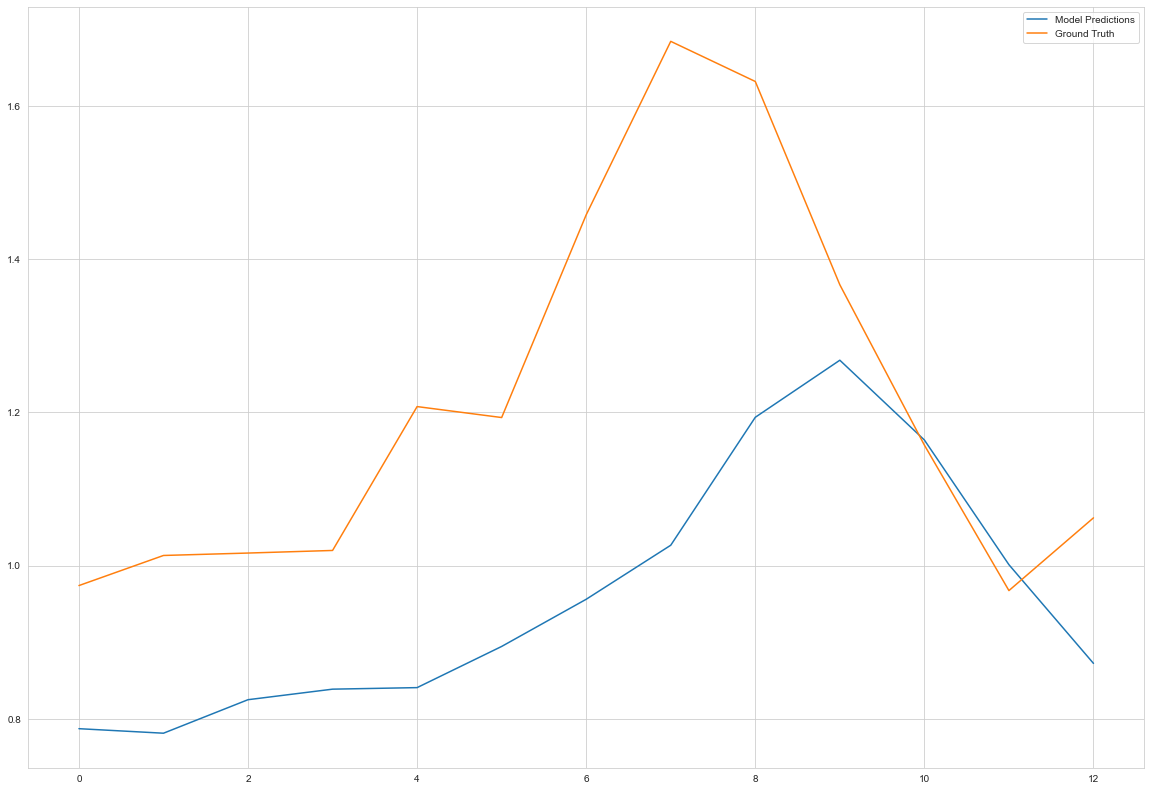

In [46]:
res_df.plot(figsize=(20, 14)) 
plt.grid(True)
#plt.gca().set_ylim(-2, 1.5) 